<a href="https://colab.research.google.com/github/amritgos/FinRL/blob/master/Portfolio_Model_Base_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/amritgos/FinRL.git

  Cloning https://github.com/amritgos/FinRL.git to /tmp/pip-req-build-amfnu49y
  Running command git clone -q https://github.com/amritgos/FinRL.git /tmp/pip-req-build-amfnu49y
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-91hxatzx/pyfolio_706f81ccbfef4869b1d7a71794b43c41
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-91hxatzx/pyfolio_706f81ccbfef4869b1d7a71794b43c41
     |████████████████████████████████| 161 kB 8.5 MB/s 
     |████████████████████████████████| 54.0 MB 42 kB/s 
     |████████████████████████████████| 1.8 MB 39.2 MB/s 
     |████████████████████████████████| 124 kB 52.6 MB/s 
     |████████████████████████████████| 108 kB 43.6 MB/s 
     |████████████████████████████████| 2.0 MB 36.5 MB/s 
     |████████████████████████████████| 153 kB 51.7 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 1.3 MB

In [2]:
!git clone https://github.com/amritgos/FinRL.git

Cloning into 'FinRL'...
remote: Enumerating objects: 3706, done.
remote: Total 3706 (delta 0), reused 0 (delta 0), pack-reused 3706
Receiving objects: 100% (3706/3706), 44.78 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (2214/2214), done.


In [3]:
cd FinRL

/content/FinRL


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [6]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [7]:
df = YahooDownloader(start_date = '2011-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.SENSEX_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2011-01-03,289.799988,294.880005,286.019989,263.478271,107300.0,ASIANPAINT.BO,0
1,2011-01-03,271.450012,274.399994,268.429993,252.560501,1603895.0,AXISBANK.BO,0
2,2011-01-03,1559.949951,1564.949951,1470.000000,1108.281250,114420.0,BAJAJ-AUTO.BO,0
3,2011-01-03,456.908142,466.635864,453.223419,457.380615,5717.0,BAJAJFINSV.BO,0
4,2011-01-03,68.483635,68.488495,67.517021,64.054726,17478.0,BAJFINANCE.BO,0


In [9]:
df.index

RangeIndex(start=0, stop=73830, step=1)

In [10]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')
sentiment_df

,date,tweets,news,tic
0,2016-01-01,NaN,NaN,NaN
1,2016-01-01,NaN,NaN,NaN
2,2016-01-01,NaN,NaN,NaN
3,2016-01-01,NaN,NaN,NaN
4,2016-01-01,NaN,NaN,NaN
...,...,...,...,...
54835,2021-01-01,0.043554,0.086588,SUNPHARMA.BO
54836,2021-01-01,0.000000,0.131225,TCS.BO
54837,2021-01-01,0.009032,0.110170,TECHM.BO
54838,2021-01-01,0.000000,0.102403,TITAN.BO


In [28]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_turbulence=False,
                    use_vix=False,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = True)

processed = fe.preprocess_data(df)

Successfully added Sentiment Features
Successfully added user defined features


In [29]:
def add_covariance_matrix(df):
    # add covariance matrix as states
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]

    cov_list = []
    return_list = []

    # look back is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)

        covs = return_lookback.cov().values 
        cov_list.append(covs)

    
    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)

    # df1 = pd.DataFrame()
    # for i in range(len(df['tic'].unique())):
    #   tics = df['tic'].unique()[i]
    #   df_tic = df.loc[df.tic == tics]
    #   df_tic['cov'] = [list() for x in range(len(df_tic.index))]
    #   for iter in df_tic.index:
    #     df_tic['cov'][iter] = df_tic['cov_list'][iter][i]
    #   # print(df_tic)
    #   df1 = df1.append(df_tic)
    # df1['cov_list'] = df1['cov']
    # df1 = df1.drop('cov', axis=1)
    # df1 = df1.sort_values(['date','tic']).reset_index(drop=True)

    return df
        

In [30]:
processed = add_covariance_matrix(processed)
processed = processed.drop('return_list', axis=1)
processed.head()

,date,open,high,low,close,volume,tic,day,tweets,news,daily_return,return_lag_1,return_lag_2,cov_list
0,2012-01-13,275.000000,279.000000,272.399994,256.217102,83910.0,ASIANPAINT.BO,4,0.0,0.0,0.010963,0.020566,0.040859,"[[0.00019418412422132666, 9.193799553477656e-0..."
1,2012-01-13,189.619995,191.199997,185.729996,175.493973,1532830.0,AXISBANK.BO,4,0.0,0.0,-0.001488,0.006642,0.047550,"[[0.00019418412422132666, 9.193799553477656e-0..."
2,2012-01-13,1473.000000,1487.050049,1422.000000,1104.013672,51828.0,BAJAJ-AUTO.BO,4,0.0,0.0,-0.029629,-0.016139,0.000000,"[[0.00019418412422132666, 9.193799553477656e-0..."
3,2012-01-13,451.405609,452.977753,443.200897,441.904541,7200.0,BAJAJFINSV.BO,4,0.0,0.0,-0.001538,0.036146,0.042685,"[[0.00019418412422132666, 9.193799553477656e-0..."
4,2012-01-13,62.756832,63.169704,61.911655,59.729336,195662.0,BAJFINANCE.BO,4,0.0,0.0,-0.007459,-0.011791,0.028119,"[[0.00019418412422132666, 9.193799553477656e-0..."


In [31]:
train = data_split(processed, '2011-01-01','2019-01-01')
train

,date,open,high,low,close,volume,tic,day,tweets,news,daily_return,return_lag_1,return_lag_2,cov_list
0,2012-01-13,275.000000,279.000000,272.399994,256.217102,83910.0,ASIANPAINT.BO,4,0.000000,0.000000,0.010963,0.020566,0.040859,"[[0.00019418412422132666, 9.193799553477656e-0..."
0,2012-01-13,189.619995,191.199997,185.729996,175.493973,1532830.0,AXISBANK.BO,4,0.000000,0.000000,-0.001488,0.006642,0.047550,"[[0.00019418412422132666, 9.193799553477656e-0..."
0,2012-01-13,1473.000000,1487.050049,1422.000000,1104.013672,51828.0,BAJAJ-AUTO.BO,4,0.000000,0.000000,-0.029629,-0.016139,0.000000,"[[0.00019418412422132666, 9.193799553477656e-0..."
0,2012-01-13,451.405609,452.977753,443.200897,441.904541,7200.0,BAJAJFINSV.BO,4,0.000000,0.000000,-0.001538,0.036146,0.042685,"[[0.00019418412422132666, 9.193799553477656e-0..."
0,2012-01-13,62.756832,63.169704,61.911655,59.729336,195662.0,BAJFINANCE.BO,4,0.000000,0.000000,-0.007459,-0.011791,0.028119,"[[0.00019418412422132666, 9.193799553477656e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,2018-12-31,429.799988,432.299988,425.649994,419.215637,464991.0,SUNPHARMA.BO,0,-0.033368,0.039227,0.014249,0.044506,0.040217,"[[0.00021099694933575367, 7.639020072756955e-0..."
1713,2018-12-31,1901.000000,1910.150024,1887.000000,1779.429443,155314.0,TCS.BO,0,0.000000,0.046776,-0.001187,-0.008327,0.002143,"[[0.00021099694933575367, 7.639020072756955e-0..."
1713,2018-12-31,716.000000,724.200012,715.400024,660.063171,50512.0,TECHM.BO,0,0.000000,-0.124014,0.012354,0.018359,0.038077,"[[0.00021099694933575367, 7.639020072756955e-0..."
1713,2018-12-31,928.000000,939.000000,920.700012,916.568726,163019.0,TITAN.BO,0,0.000000,0.031650,0.008076,0.047064,0.045886,"[[0.00021099694933575367, 7.639020072756955e-0..."


In [122]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df, 
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                sentiment_indicator_list,
                user_indicator_list,
                turbulence_threshold=None,
                vix_threshold=None,
                risk_indicator_col='turbulence',
                make_plots = False, 
                print_verbosity = 10,
                day = 0, 
                initial=True,
                previous_state=[],
                model_name = '',
                mode='',
                iteration=''):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.sentiment_indicator_list = sentiment_indicator_list
        self.user_indicator_list = user_indicator_list
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,))
        self.data = self.df.loc[self.day,:]
        self.cov_mat = self.data['cov_list'].values[0]
        self.covs = self.data['cov_list'].values[0][np.triu_indices(self.stock_dim)].flatten()
        self.terminal = False     
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.vix_threshold = vix_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name=model_name
        self.mode=mode 
        self.iteration=iteration
        # initalize state
        self.state = self._initiate_state()
        
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.vix = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        #self.reset()
        self._seed()
        


    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index+1]>0: 
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index+self.stock_dim+1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(abs(action),self.state[index+self.stock_dim+1])
                    sell_amount = self.state[index+1] * sell_num_shares * (1- self.sell_cost_pct)
                    #update balance
                    self.state[0] += sell_amount

                    self.state[index+self.stock_dim+1] -= sell_num_shares
                    self.cost +=self.state[index+1] * sell_num_shares * self.sell_cost_pct
                    self.trades+=1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares
            
        # perform sell action based on the sign of the action
        if (self.turbulence_threshold is not None) or (self.vix_threshold is not None):
            if (self.turbulence>=self.turbulence_threshold) or (self.vix>=self.vix_threshold):
                if self.state[index+1]>0: 
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions 
                    if self.state[index+self.stock_dim+1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index+self.stock_dim+1]
                        sell_amount = self.state[index+1]*sell_num_shares* (1- self.sell_cost_pct)
                        #update balance
                        self.state[0] += sell_amount
                        self.state[index+self.stock_dim+1] =0
                        self.cost += self.state[index+1]*sell_num_shares* \
                                    self.sell_cost_pct
                        self.trades+=1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    
    def _buy_stock(self, index, action):

        def _do_buy():
            if self.state[index+1]>0: 
                #Buy only if the price is > 0 (no missing data in this particular date)       
                available_amount = self.state[0] // self.state[index+1]
                # print('available_amount:{}'.format(available_amount))
                
                #update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = self.state[index+1] * buy_num_shares * (1+ self.buy_cost_pct)
                self.state[0] -= buy_amount

                self.state[index+self.stock_dim+1] += buy_num_shares
                
                self.cost+=self.state[index+1] * buy_num_shares * self.buy_cost_pct
                self.trades+=1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if (self.turbulence_threshold is None) or (self.vix_threshold is None):
            buy_num_shares = _do_buy()
        else:
            if (self.turbulence < self.turbulence_threshold) and (self.vix < self.vix_threshold):
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory,'r')
        plt.savefig('results/account_value_trade_{}.png'.format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()            
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount 
            df_total_value.columns = ['account_value']
            df_total_value['date'] = self.date_memory
            df_total_value['daily_return']=df_total_value['account_value'].pct_change(1)
            if df_total_value['daily_return'].std() !=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ['account_rewards']
            df_rewards['date'] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value['daily_return'].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name!='') and (self.mode!=''):
                df_actions = self.save_action_memory()
                df_actions.to_csv('results/actions_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration))
                df_total_value.to_csv('results/account_value_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                df_rewards.to_csv('results/account_rewards_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.plot(self.asset_memory,'r')
                plt.savefig('results/account_value_{}_{}_{}.png'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.close()

            # Add outputs to logger interface
            #logger.record("environment/portfolio_value", end_total_asset)
            #logger.record("environment/total_reward", tot_reward)
            #logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            #logger.record("environment/total_cost", self.cost)
            #logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax #actions initially is scaled between 0 to 1
            actions = (actions.astype(int)) #convert into integer because we can't by fraction of shares
            if (self.turbulence_threshold is not None) or (self.vix_threshold is not None):
                if (self.turbulence>=self.turbulence_threshold) or (self.vix>=self.vix_threshold) :
                    actions=np.array([-self.hmax]*self.stock_dim)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)
            
            #state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day,:]    
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            if self.vix_threshold is not None:     
                self.vix = self.data['VIX'].values[0]
            self.state = self._update_state()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            weights = np.zeros(shape=[self.stock_dim,1])
            for stock_iter in range(self.stock_dim):
              weights[stock_iter,0] = self.state[1+stock_iter]*self.state[self.stock_dim+1+stock_iter]/end_total_asset
            
            # print('wts', weights.shape)
            # print('cov', self.cov_mat.shape)
            port_variance = np.matmul(weights.T,np.matmul(self.cov_mat,weights))[0,0]

            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = (end_total_asset - begin_total_asset)/(begin_total_asset*port_variance**0.5)          
            self.rewards_memory.append(self.reward)
            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        #initiate state
        self.state = self._initiate_state()
        
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        
        self.episode+=1

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.initial_amount] + \
                         self.data.close.values.tolist() + \
                         [0]*self.stock_dim  + \
                         self.covs.tolist() + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], []) + \
                         sum([self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], []) + \
                         sum([self.data[us].values.tolist() for us in self.user_indicator_list ], [])
            else:
                # for single stock
                state = [self.initial_amount] + \
                        [self.data.close] + \
                        [0]*self.stock_dim  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        else:
            #Using Previous State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.previous_state[0]] + \
                         self.data.close.values.tolist() + \
                         self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                         self.covs.tolist() + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], []) + \
                         sum([self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], []) + \
                         sum([self.data[us].values.tolist() for us in self.user_indicator_list ], [])
            else:
                # for single stock
                state = [self.previous_state[0]] + \
                        [self.data.close] + \
                        self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        return state

    def _update_state(self):
        if len(self.df.tic.unique())>1:
            # for multiple stock
            state =  [self.state[0]] + \
                      self.data.close.values.tolist() + \
                      list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      self.covs.tolist() + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], []) + \
                      sum([self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], []) + \
                      sum([self.data[us].values.tolist() for us in self.user_indicator_list ], [])
            
        else:
            # for single stock
            state =  [self.state[0]] + \
                     [self.data.close] + \
                     list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                     sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
                          
        return state

    def _get_date(self):
        if len(self.df.tic.unique())>1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique())>1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ['date']
            
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [123]:
sent = 1
tech = 0
user = 1
stock_dimension = len(processed.tic.unique())
state_space = int(1 + 2*stock_dimension + (stock_dimension + (stock_dimension*(stock_dimension-1))/2) + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension)
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 676


In [124]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 10000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    # "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 10,
    "print_verbosity":5
}

# print(config.TECHNICAL_INDICATORS_LIST,config.SENTIMENT_INDICATORS_LIST,config.USER_INDICATORS_LIST)

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [125]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
# initialize
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_15
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | 1.08e+03 |
|    std                | 1.02     |
|    value_loss         | 601      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 200      |
|    time_elapsed       | 10       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -43.6    |
|    explained_variance | 0        

In [50]:
trade = data_split(processed,'2019-01-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [51]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [52]:
df_daily_return.to_csv('df_returns.csv')

In [53]:
df_actions.to_csv('df_actions.csv')

In [54]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [55]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.153601
Cumulative returns     0.321770
Annual volatility      0.343542
Sharpe ratio           0.592483
Calmar ratio           0.327062
Stability              0.023397
Max drawdown          -0.469638
Omega ratio            1.121180
Sortino ratio          0.788483
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.938840
Daily value at risk   -0.042474
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (490, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,23
,Backtest
Annual return,15.497%
Cumulative returns,32.332%
Annual volatility,34.389%
Sharpe ratio,0.59
Calmar ratio,0.33
Stability,0.02
Max drawdown,-46.964%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.96,2020-02-12,2020-04-03,2020-11-18,201
1,16.57,2019-06-03,2019-08-22,2020-01-13,161
2,9.65,2019-01-02,2019-01-28,2019-03-05,45
3,7.32,2019-04-26,2019-05-13,2019-05-20,17
4,4.35,2020-12-17,2020-12-21,2020-12-30,10


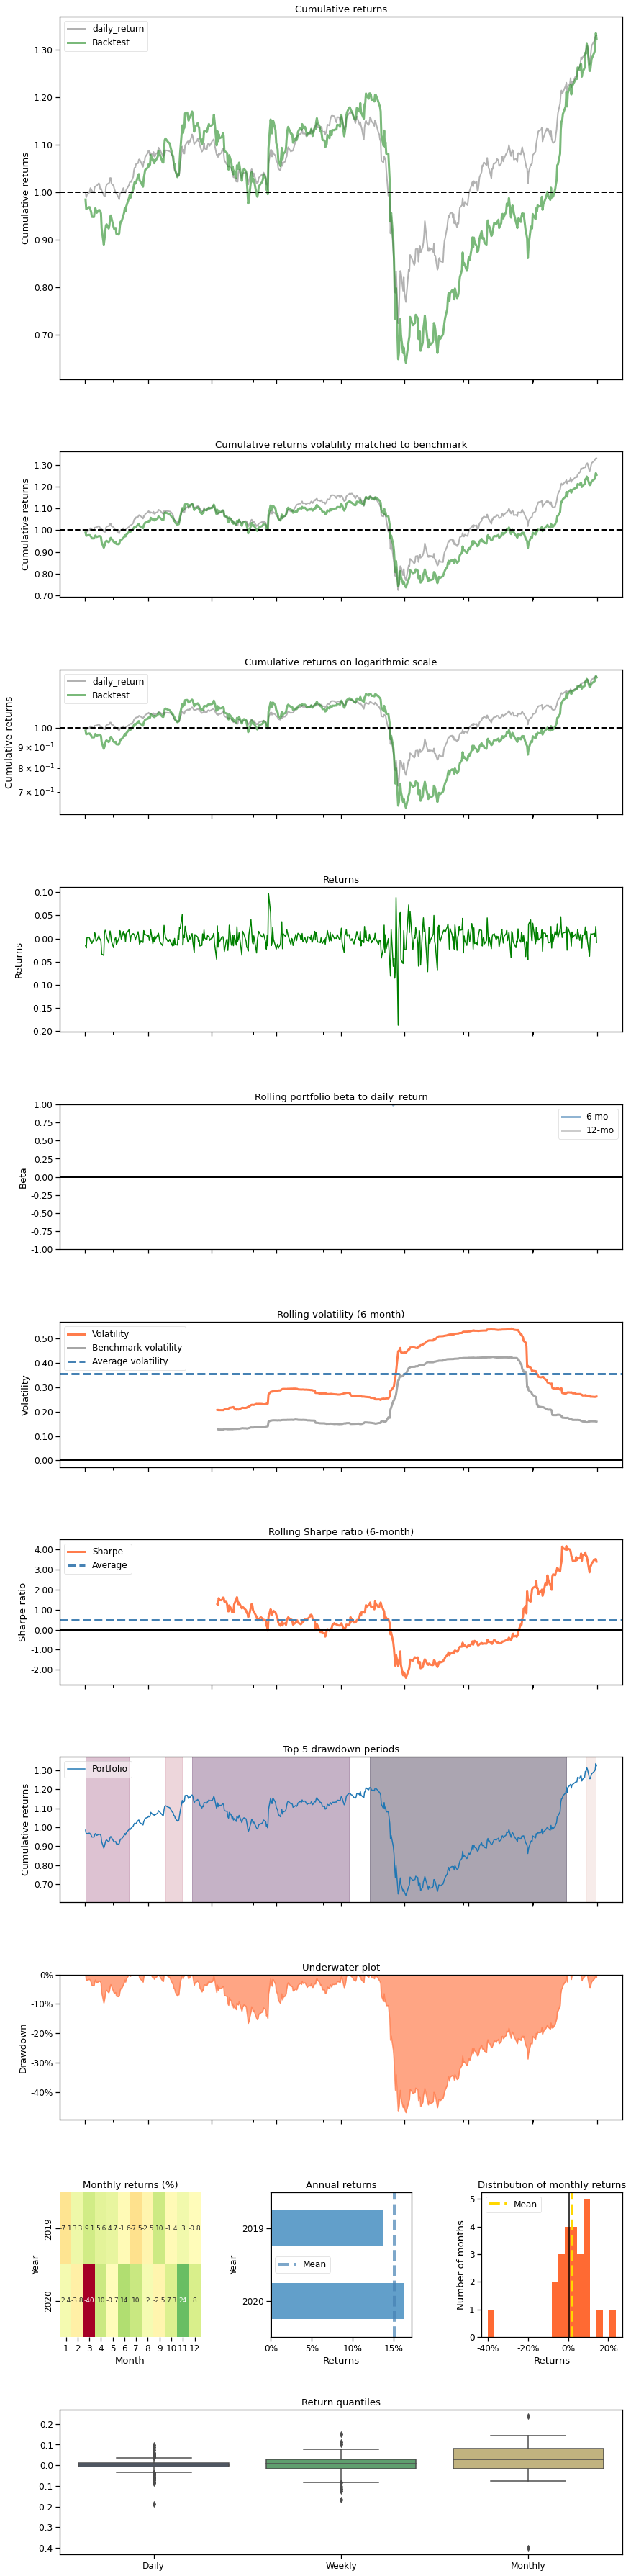

In [56]:
import pyfolio
import datetime as dt
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-01-01', end='2021-01-01')


baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)